# "Introduction to Graph Representation Learning"
## Szkoła letnia AI-Tech 2023
### Autor: Piotr Bielak

![Logotypy sponsorów](../sponsors.png)

Grafy opisują obiekty i relacje między obiektami. Możemy je spotkać w wielu dziedzinach, takich jak analiza mediów społecznościowych (użytkownicy portali i interakcje między nimi), chemii obliczeniowej (cząsteczki jako atomy połączone za pomocą wiązań atomowych) czy astronomii (relacje grawitacyjne między ciałami niebieskimi).

Grafy nie muszą koniecznie opisywać danych, które mają bezpośrednio strukturę sieciową. Możemy również zastosować metody przetwarzania grafów do opisu tradycyjnych typów danych, np. dla zbioru obrazów możemy obliczyć ich podobieństwa i jeśli to podobieństwo jest większe niż zadana wartość progowa, to tworzymy między takimi obrazami krawędź; jeśli na obrazie znajduje się kilka obiektów, możemy opisać ich względne położenia za pomocą krawędzi o różnych typach (np. "X znajduje się z lewej strony Y", "X przesłania część Y" itd.).

In [1]:
!pip install -r requirements.txt

Looking in links: https://download.pytorch.org/whl/torch_stable.html, https://data.pyg.org/whl/torch-2.0.0+cu118.html


## 1. Graf

$$\Large\mathcal{G} = (\mathcal{V}, \mathcal{E}, \mathbf{X}),$$

gdzie $\mathcal{V}$ to zbiór wierzchołków, a $\mathcal{E} \in \mathcal{V} \times \mathcal{V}$ to zbiór krawędzi łączących pary wierzchołków. 

Z każdym wierzchołkiem $u$ skojarzony jest wektor atrybutów $\mathbf{x}_u \in \mathbb{R}^{d}$. Cechy wszystkich wierzchołków są opisane przez macierz $\mathbf{X} \in \mathbb{R}^{|\mathcal{V}| \times d}$. Podobnie można zdefiniować atrybuty krawędzi oraz atrybuty całego grafu, przy czym dla uproszczenia przyjmiemy, że tylko wierzchołki posiadają atrybuty.

$$\Large A \in \{0, 1\}^{|\mathcal{V}| \times |\mathcal{V}|}$$

W celu opisania połączeń w grafie stosuje się najczęściej (binarną) macierz sąsiedztwa $A \in \{0, 1\}^{|\mathcal{V}| \times |\mathcal{V}|}$, w której: $A_{uv} = 1 \iff (u, v) \in \mathcal{E}$. Macierz ta jest macierzą symetryczną dla grafów nieskierowanych (krawędź nie ma kierunku), natomiast w przypadku grafów skierowanych raczej jest macierzą niesymetryczną.

Innym sposobem opisu połączeń jest lista krawędzi. Motywacją do stosowania takiego zapisu jest fakt, że najczęściej graf jest rzadki, tzn. liczba krawędzi jest znacząco mniejsza niż maksymalna liczba możliwych krawędzi -- $|\mathcal{E}| \ll |\mathcal{V}|  \times |\mathcal{V}|$.

## 2. Przykłady grafów

- **sieci społeczne**
- sieci telekomunikacyjne
- sieci dróg
- **cząsteczki chemiczne**
- sieci artykułów naukowych (cytowań)
- **systemy rekomendacyjne**
- portale zakupowe (e-commerce)
- ...

![](https://i.insider.com/4f5112e169bedd1526000061?width=700&format=jpeg&auto=webp)

[Źródło: Business Insider](https://www.businessinsider.com/explainer-what-exactly-is-the-social-graph-2012-3?IR=T)

![](https://www.wolfram.com/language/12/molecular-structure-and-computation/assets.en/molecule-graphs/O_84.png) | ![](https://www.wolfram.com/language/12/molecular-structure-and-computation/assets.en/molecule-graphs/O_82.png)
- | - 
[Źródło: Wolfram [1]](https://www.wolfram.com/language/12/molecular-structure-and-computation/assets.en/molecule-graphs/O_84.png) | [Źródło: Wolfram [2]](https://www.wolfram.com/language/12/molecular-structure-and-computation/assets.en/molecule-graphs/O_82.png)

![](https://media.springernature.com/lw685/springer-static/image/art%3A10.1007%2Fs00521-020-05667-z/MediaObjects/521_2020_5667_Fig2_HTML.png)
[Źródło: Springer](https://link.springer.com/article/10.1007/s00521-020-05667-z)

## 3. PyTorch-Geometric

Bibliotek wykorzystywanych do uczenia modeli działających na danych grafowych jest wiele, jednak dwie z nich są bardzo często stosowane: **PyTorch-Geometric** (**PyG**; [dokumentacja](https://pytorch-geometric.readthedocs.io/en/latest/)) oraz **Deep Graph Library** (w skrócie DGL; [dokumentacja](https://docs.dgl.ai)). W ramach warsztatów będzie wykorzystywana biblioteka PyTorch-Geometric, jednak zachęcam zainteresowanych do zapoznania się również z DGL.

PyG zawiera wiele gotowych do użycia: 
- zbiorów danych (grafy jednorelacyjne i heterogeniczne, małe i wielkoskalowe, zbiory z wieloma grafami itp.), 
- warstw stosowanych w grafowych sieciach neuronowych (GNN)
- modeli sieci neuronowych do przetwarzania grafów,
- funkcji do przetwarzania i przygotowania danych grafowych.

## 3.1. `Data(...)`

Podstawową strukturą danych opisującą grafy w PyG jest obiekt typu `Data(...)`. Opisujemy nim proste grafy homogeniczne (jeden typ wierzchołków i jeden typ krawędzi) w następującej postaci:
- atrybuty wierzchołków - tensor `data.x`
- listę krawędzi - tensor `data.edge_index` w formacie COO (o wymiarach $2 \times |\mathcal{E}|$)
- (opcjonalnie) klasy wierzchołków / krawędzi / grafu - tensor `data.y` (wymiar zależny od problemu)
- (opcjonalnie) atrybuty krawędzi - tensor `data.edge_attr`
- pola zawierające informacje o liczbie krawędzi, liczbie wierzchołków oraz wymiarowościach ich atrybutów,
- inne pola, które pomijamy w trakcie tego laboratorium.

W przypadku problemów, gdzie działamy na zbiorze składającym się z wielu grafów, każdy z nich jest opisany przez osobny obiekt `Data`. 

Zacznijmy od załadowania zbioru `Cora`. Jest to zbiór, w którym wierzchołki opisują publikacje naukowe, natomiast krawędzie opisują cytowania między artykułami. Każdy wierzchołek jest opisany przez binarny wektor worka słów użytych w artykule (ang. *binary bag-of-words*). Każdy artykuł / wierzchołek posiada przypisaną klasę. Zbiór ten można zastosować w tzw. problemie klasyfikacji wierzchołków lub problemie predykcji połączeń. Obecnie zbiór nie jest już stosowany do porównywania metod uczenia reprezentacji na grafach, głównie ze względu na wielkość (mały zbiór) oraz wysoką homofilię (podobne wierzchołki są połączone do podobnych wierzchołków).

In [2]:
import torch

torch.manual_seed(42)

In [3]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root="/tmp/Cora/", name="Cora")

print(f"Liczba grafów: {len(dataset)}")

data = dataset[0]

data

Liczba grafów: 1


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

**Podstawowe statystyki:**

In [4]:
print("Liczba wierzchołków:", data.num_nodes)
print("Liczba krawędzi:", data.num_edges)
print("Wymiarowość atrybutów wierzchołków:", data.num_node_features)
print("Czy skierowany?", data.is_directed())
print("Liczba typów wierzchołków:", data.num_node_types)
print("Liczba typów krawędzi:", data.num_edge_types)

Liczba wierzchołków: 2708
Liczba krawędzi: 10556
Wymiarowość atrybutów wierzchołków: 1433
Czy skierowany? False
Liczba typów wierzchołków: 1
Liczba typów krawędzi: 1


In [5]:
print("Liczba klas wierzchołków:", dataset.num_classes)

# Alternatywnie
print("Liczba klas wierzchołków:", data.y.unique().shape[0])

Liczba klas wierzchołków: 7
Liczba klas wierzchołków: 7


**Atrybuty wierzchołków:**

In [6]:
data.x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

**Macierz sąsiedztwa (rzadka; COO):**

In [7]:
data.edge_index

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])

**Etykiety wierzchołków:**

In [8]:
data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

**Wizualizacja sieci:**

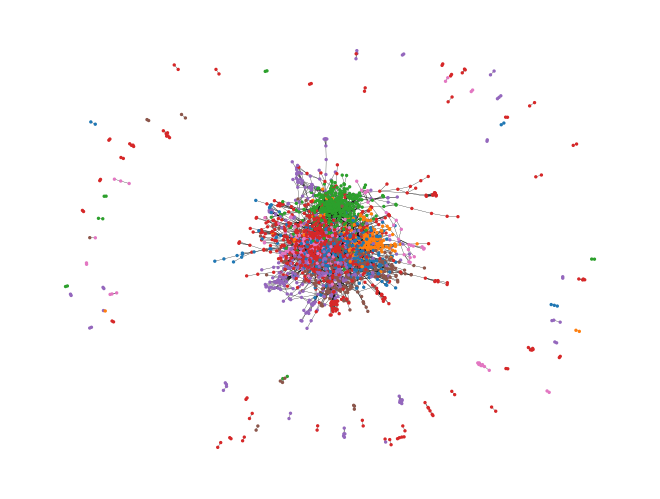

In [9]:
import networkx as nx
import seaborn as sns
from torch_geometric.utils import to_networkx


nx_graph = to_networkx(data, to_undirected=True)

pos = nx.spring_layout(nx_graph)
cm = sns.color_palette(n_colors=data.y.unique().shape[0])
node_color = [cm[y] for y in data.y]

nx.draw(nx_graph, pos=pos, node_size=2, node_color=node_color, width=0.2)

## 3.2. `HeteroData(...)`

W przypadku gdy graf posiada wiele typów wierzchołków lub/i wiele typów krawędzi to mówimy o **grafach heterogenicznych**. Takie grafy są opisywane za pomocą obiektów typu `HeteroData(...)`. Każdy typ wierzchołka może mieć przypisane osobne atrybuty (i inne pola), a każdy typ krawędzi posiada co najmniej listę krawędzi (macierz sąsiedztwa; *edge_index*).

Przykładowym grafem heterogenicznym jest **IMDB**, który jest zbiorem filmów, reżyserów oraz aktorów. Każdy film jest opisany przez slowa kluczowe w postaci worka słów (*bag-of-words*). Etykietą filmów jest jego gatunek (akcja, komedia, dramat). Krawędzie są zdefiniowane pomiędzy filmem a reżyserem oraz filmem a aktorami (wraz z krawędziami zwrotnymi).

In [10]:
from torch_geometric.datasets import IMDB

hetero_dataset = IMDB(root="/tmp/IMDB/")

print("Liczba grafów:", len(hetero_dataset))

hetero_data = hetero_dataset[0]

hetero_data

Extracting /tmp/IMDB/raw/IMDB_processed.zip
Processing...


Liczba grafów: 1


Done!


HeteroData(
  movie={
    x=[4278, 3066],
    y=[4278],
    train_mask=[4278],
    val_mask=[4278],
    test_mask=[4278]
  },
  director={ x=[2081, 3066] },
  actor={ x=[5257, 3066] },
  (movie, to, director)={ edge_index=[2, 4278] },
  (movie, to, actor)={ edge_index=[2, 12828] },
  (director, to, movie)={ edge_index=[2, 4278] },
  (actor, to, movie)={ edge_index=[2, 12828] }
)

In [11]:
print("Czy skierowany?", hetero_data.is_directed())

Czy skierowany? False


In [12]:
print("Łączna liczba wierzchołków:", hetero_data.num_nodes)
print("Typy wierzchołków:", hetero_data.node_types)
print("Wymiarowość atrybutów wierzchołków:", hetero_data.num_node_features)

Łączna liczba wierzchołków: 11616
Typy wierzchołków: ['movie', 'director', 'actor']
Wymiarowość atrybutów wierzchołków: {'movie': 3066, 'director': 3066, 'actor': 3066}


In [13]:
print("Łączna liczba krawędzi:", hetero_data.num_edges)
print("Typy krawędzi:", hetero_data.edge_types)

Łączna liczba krawędzi: 34212
Typy krawędzi: [('movie', 'to', 'director'), ('movie', 'to', 'actor'), ('director', 'to', 'movie'), ('actor', 'to', 'movie')]


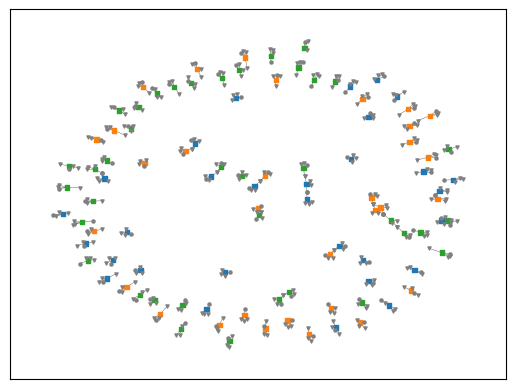

In [14]:
# Subsample some movies
import torch
from torch_geometric.utils import bipartite_subgraph

N_movies = 100

movies = torch.randperm(hetero_data["movie"].num_nodes)[:N_movies]

m_to_d = bipartite_subgraph(
    subset=(movies, torch.arange(hetero_data["director"].num_nodes)), 
    edge_index=hetero_data["movie", "to", "director"].edge_index,
)[0]

m_to_a = bipartite_subgraph(
    subset=(movies, torch.arange(hetero_data["actor"].num_nodes)), 
    edge_index=hetero_data["movie", "to", "actor"].edge_index,
)[0]

# Convert heterogeneous graph to NetworkX
nx_hetero_graph = nx.Graph()

movie_nodes = [f"Movie_{i}" for i in movies.tolist()]
director_nodes = [f"Director_{i}" for i in m_to_d[1].tolist()]
actor_nodes = [f"Actor_{i}" for i in m_to_a[1].tolist()]

nx_hetero_graph.add_nodes_from(movie_nodes + director_nodes + actor_nodes)

nx_hetero_graph.add_edges_from([
    (f"Movie_{src}", f"Director_{dst}")
    for src, dst in m_to_d.t().tolist()
])

nx_hetero_graph.add_edges_from([
    (f"Movie_{src}", f"Actor_{dst}")
    for src, dst in m_to_a.t().tolist()
])

# Draw the graph
pos = nx.spring_layout(nx_hetero_graph)

nx.draw_networkx_nodes(
    nx_hetero_graph, 
    pos=pos, 
    nodelist=movie_nodes, 
    node_shape="s", 
    node_size=10,
    node_color=[cm[hetero_data["movie"].y[int(node.split("_")[1])]] for node in movie_nodes]
)
nx.draw_networkx_nodes(
    nx_hetero_graph, 
    pos=pos,
    nodelist=director_nodes, 
    node_shape="o", 
    node_size=5, 
    node_color="gray",
)
nx.draw_networkx_nodes(
    nx_hetero_graph, 
    pos=pos, 
    nodelist=actor_nodes, 
    node_shape="v", 
    node_size=5,
    node_color="gray",
)
nx.draw_networkx_edges(nx_hetero_graph, pos=pos, width=0.2)

## 3.3. Multiple graph dataset

W przypadku gdy zbiór składa się z wielu grafów, po wczytaniu zbioru otrzymujemy listę obiektów `Data(...)` lub `HeteroData(...)`. Najczęściej takie zbiory są używane w chemii obliczeniowej, gdzie pojedynczy graf odpowiada jednej cząsteczce. Poniżej przedstawiono zbiór **ENZYMES** składający się z 600 cząsteczek/grafów. Atomy są modelowane jako wierzchołki, a wiązania atomowe jako krawędzie. Celem jest klasyfikacja każdej cząsteczki.

In [15]:
from torch_geometric.datasets import TUDataset


multi_dataset = TUDataset(root="/tmp/ENZYMES/", name="ENZYMES", use_node_attr=True)

print("Liczba grafów:", len(multi_dataset))


print(multi_dataset[0])
print(multi_dataset[1])
print(multi_dataset[2])

Extracting /tmp/ENZYMES/ENZYMES/ENZYMES.zip
Processing...


Liczba grafów: 600
Data(edge_index=[2, 168], x=[37, 21], y=[1])
Data(edge_index=[2, 102], x=[23, 21], y=[1])
Data(edge_index=[2, 92], x=[25, 21], y=[1])


Done!


In [16]:
print("Liczba klas grafów:", multi_dataset.num_classes)

Liczba klas grafów: 6


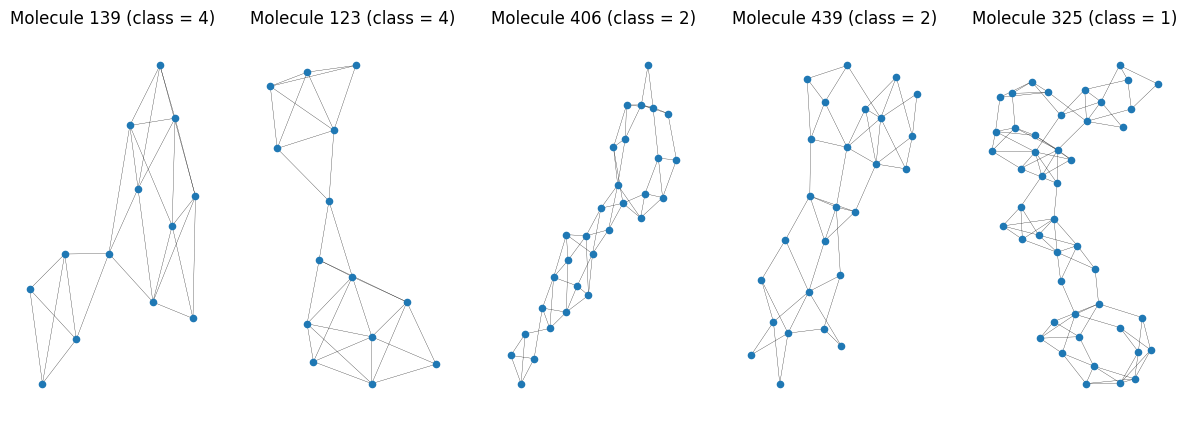

In [17]:
import matplotlib.pyplot as plt

N_molecules = 5
fig, axs = plt.subplots(ncols=N_molecules, figsize=(15, 5))

for idx, ax in zip(
    torch.randperm(len(multi_dataset))[:N_molecules].tolist(),
    axs,
):
    molecule = to_networkx(multi_dataset[idx], to_undirected=True)
    pos = nx.kamada_kawai_layout(molecule)
    nx.draw(molecule, pos=pos, ax=ax, node_size=20, width=0.2)
    ax.set(title=f"Molecule {idx} (class = {multi_dataset[idx].y.item()})")